In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astro_models
from astropy import constants as const
import os
import emcee

### Initial Astro Guess

In [2]:
t0   = 59767.55 #transit time
per  = 0.7920520     #Orbital period.
rp   = 0.0455        #Planet radius (in units of stellar radii).
a    = 3.877         #Semi-major axis (in units of stellar radii).
inc  = 76.39         #Orbital inclination (in degrees).
ecosw= 0.0           #Eccentricity multiplied by the cosine of the longitude of periastron (value between -1 and 1).
esinw= 0.0           #Eccentricity multiplied by the sine of the longitude of periastron (value between -1 and 1).
q1   = 0.01          #Limb darkening coefficient 1, parametrized to range between 0 and 1.
q2   = 0.01          #Limb darkening coefficient 2, parametrized to range between 0 and 1.
fp   = 0.000358      #Planet-to-star flux ratio.
A    = 0.35          #Amplitude of the first-order cosine term.
B    = 0.0001        #Amplitude of the first-order sine term.
C    = 0.0           #(optional): Amplitude of the second-order cosine term. Default=0.
D    = 0.0           #(optional): Amplitude of the second-order sine term. Default=0.
r2   = None          #(optional): Planet radius along sub-stellar axis (in units of stellar radii). Default=None.
r2off= None          #(optional): Angle to the elongated axis with respectto the sub-stellar axis (in degrees). 
                     #Default=None.

time = np.linspace(t0-0.7*per, t0+0.7*per, 1000) #Array of times at which to calculate the model.
time = np.linspace(58782.54689555371, 58783.48559855371+2400000.5, 1000)
flux = astro_models.ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)

### Load data

### Defining Model Fit

In [3]:
def linear_trend(time, m, b):
    x = time - time.min()
    return m * x + b

def signal(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, slope_m, slope_b):
    pl = astro_models.ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D)
    lt = linear_trend(time, slope_m, slope_b)
    return pl+lt

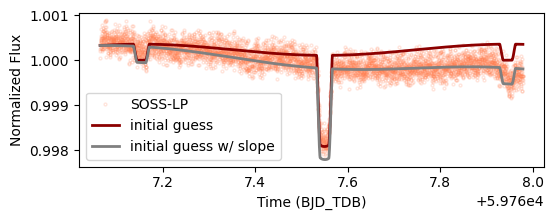

In [4]:
# Louis-Phillipe's WLC
path = 'LTT9779b-SOSS/LPC_LTT9779b_wlc_order1.txt'
data = np.loadtxt(path)
flux_LP = 1+data[1]/1e6#/np.mean(data[1])
time_LP= data[0]

#time = np.linspace(t0-0.7*per, t0+0.7*per, 1000) #Array of times at which to calculate the model.
#time = np.linspace(58782.54689555371, 58783.48559855371+2400000.5, 1000)
flux_model = astro_models.ideal_lightcurve(time_LP, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)
slope_m, slope_b = -6e-4, 0
signal_model = signal(time_LP, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, slope_m, slope_b)

plt.figure(figsize=(6,2))
plt.plot(time_LP, flux_LP, 'o', fillstyle='none', markersize=2, alpha=0.2, color='coral', label='SOSS-LP')
plt.plot(time_LP, flux_model, label='initial guess', lw=2, color='darkred')
plt.plot(time_LP, signal_model, label='initial guess w/ slope', lw=2, color='grey')
plt.xlabel('Time (BJD_TDB)')
plt.ylabel('Normalized Flux')
plt.legend()


### Defining likelihood function

In [5]:
def log_likelihood(theta, time, flux):
    t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, slope_m, slope_b, sigF = theta
    model = signal(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, slope_m, slope_b)
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, slope_m, slope_b, sigF = theta
    if (59767.54<t0<59767.56 and 0.7920055<per<0.79209849 and 0<q1<1 and 0<q2<1 and
        0<rp<1 and 0<fp<1 and 3.67<a<4 and -0.5<A<0.5):
        return 0.0
    return np.inf

def log_prob(theta, time, flux):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux)

### MCMC

In [6]:
sigF = 0.00001
p0  = np.array([t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, slope_m, slope_b, sigF])
nsteps, nwalkers, ndim = 5000, 100, len(p0)

pos = p0 + 1e-6 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time_LP, flux_LP))

pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:55<00:00,  5.58it/s]


### Saving MCMC Run

In [9]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=int(np.rint((nBurnInSteps2)/nwalkers))).swapaxes(0,1)
chain = sampler.get_chain(discard=int(np.rint((nBurnInSteps2)/nwalkers))).swapaxes(0,1)

savepath = 'LTT9779b-SOSS/LP_fit/'
#Saving MCMC Results
pathchain = savepath + 'samplerchain.npy'
pathlnlchain = savepath + 'samplerlnlchain.npy'
pathposit = savepath + 'samplerposi.npy'
pathlnpro = savepath + 'samplerlnpr.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob) 

In [10]:
samples = chain.reshape((-1, ndim))
    
MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))
 
maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

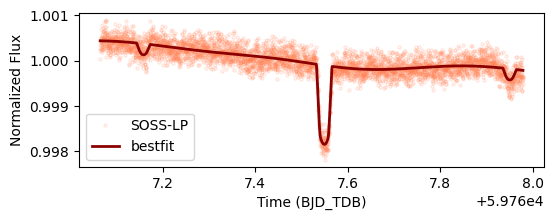

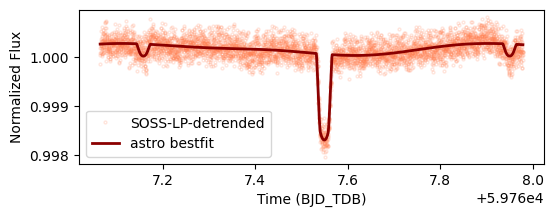

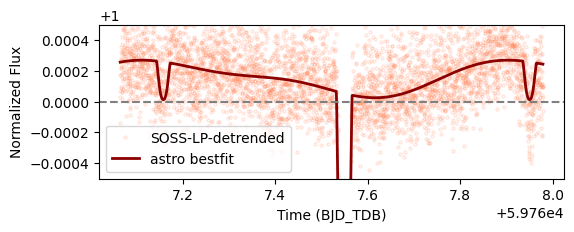

In [26]:
flux_bfit   = astro_models.ideal_lightcurve(time_LP, *p0_mcmc[:-3])
signal_bfit = signal(time_LP, *p0_mcmc[:-1])
trend_bfit  = linear_trend(time_LP, *p0_mcmc[-3:-1])

plt.figure(figsize=(6,2))
plt.plot(time_LP, flux_LP, 'o', fillstyle='none', markersize=2, alpha=0.2, color='coral', label='SOSS-LP')
plt.plot(time_LP, signal_bfit, label='bestfit', lw=2, color='darkred')
plt.xlabel('Time (BJD_TDB)')
plt.ylabel('Normalized Flux')
plt.legend()

plt.figure(figsize=(6,2))
plt.plot(time_LP, flux_LP-trend_bfit, 'o', fillstyle='none', markersize=2, alpha=0.2, 
         color='coral', label='SOSS-LP-detrended')
plt.plot(time_LP, flux_bfit, label='astro bestfit', lw=2, color='darkred')
plt.xlabel('Time (BJD_TDB)')
plt.ylabel('Normalized Flux')
plt.legend()

plt.figure(figsize=(6,2))
plt.plot(time_LP, flux_LP-trend_bfit, 'o', fillstyle='none', markersize=2, alpha=0.2, 
         color='coral', label='SOSS-LP-detrended')
plt.plot(time_LP, flux_bfit, label='astro bestfit', lw=2, color='darkred')
plt.axhline(y=1, ls='--', color='grey')
plt.ylim(0.9995, 1.0005)
plt.xlabel('Time (BJD_TDB)')
plt.ylabel('Normalized Flux')
plt.legend()

### Constraining Tday and Tnight from the phase curve
only valid for C=D=0 for now

** maybe we should fit for reflected light?**

In [20]:
wav  = 1.7*1e-6 #average wavelength 
tstar_bs = 5443

tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_bs))-1)/(fp/rp**2)))**-1
print('T_day:', np.round(tday, 2), 'K')
        
tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_bs))-1)/(fp*(1-2*A)/rp**2)))**-1
print('T_night:', np.round(tnight, 2), 'K')


T_day: 2714.53 K
T_night: 1972.67 K


### Constraining Bond Albedo and Heat Recirculation Efficiency
a la Schwartz and Cowan 2015, might have to double check math...

In [21]:
def heat_recirc(tday, tnight):
    upper = 2*tnight**4
    lower = 3*((5*tnight**4/12)+(tday**4/4))
    return upper/lower

def bond_alb(tday, tnight, epsilon, T0):
    return 1-((4*tnight**4)/(epsilon*T0**4))

def Tirr(tstar_bs, a):
    return tstar_bs*np.sqrt(1/a)

T0 = Tirr(tstar_bs, a)
print('Irradiation Temperature T0:', round(T0,2), 'K')

epsilon = heat_recirc(tday, tnight)
print('heat recirculation efficiency [0,1]:', round(epsilon,4))

A_b = bond_alb(tday, tnight, epsilon, T0)
print('Bond Albedo [0,1]:', round(A_b,2))

Irradiation Temperature T0: 2764.33 K
heat recirculation efficiency [0,1]: 0.5077
Bond Albedo [0,1]: -1.04


### Brightness Map

In [27]:
p0  = np.array([t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, slope_m, slope_b, sigF])

A_mcmc, B_mcmc, C_mcmc, D_mcmc = p0_mcmc[10], p0_mcmc[11],p0_mcmc[12],p0_mcmc[13]

Text(0, 0.5, 'latitude')

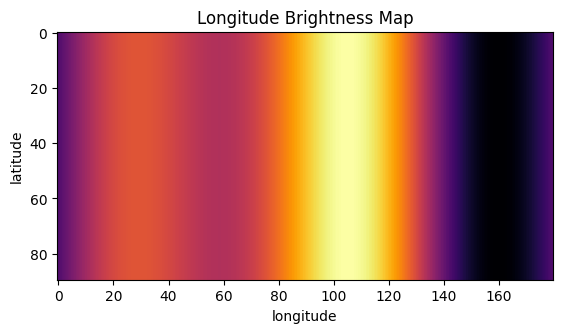

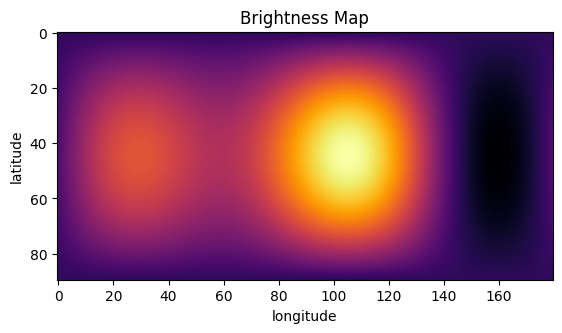

In [28]:
# transform phase curve coeff into fourier series coeff
F_0 = 1-A_mcmc-C_mcmc
C_1, D_1 = A_mcmc, B_mcmc
C_2, D_2 = C_mcmc, D_mcmc

# transform to map coeff
A_0 = F_0/2
A_1, B_1 = 2*C_1/np.pi, -2*D_1/np.pi
A_2, B_2 = 3*C_2/2, -3*D_2/2 

# longitudinal brightness
longitude = np.linspace(-np.pi, np.pi, 180)
lon_brigh = A_0 + A_1*np.cos(longitude) + A_2*np.cos(2*longitude) + B_1*np.sin(longitude) + B_2*np.sin(2*longitude)

# lon-lat map
latitude  = np.linspace(-np.pi/2, np.pi/2, 90)
latitude  = np.expand_dims(latitude, axis=1)
lon_map   = np.tile(lon_brigh, (90,1))

# double-check math... assuming spherical shape
brightmap = (3/4)*lon_map*np.cos(latitude)

plt.figure()
plt.imshow(lon_map, cmap='inferno')
plt.title('Longitude Brightness Map')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.figure()
plt.imshow(brightmap, cmap='inferno')
plt.title('Brightness Map')
plt.xlabel('longitude')
plt.ylabel('latitude')

In [ ]:
# Clear out the RAM
samples = None
sampler = None
chain = None
lnprobchain = None